### Data Processing and Manipulation / Feature Engineering

Import necessary libaries and modules

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import os
import json
import ast

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Retrieving data from another source of code where we parsed through many json files (from events) and merged all events in the games into a single dataframe

In [ ]:
shots = pd.read_csv('/content/drive/My Drive/142 Final Project/shots.csv')

In [ ]:
shots.columns

Index(['Unnamed: 0', 'level_0', 'id', 'index', 'period', 'timestamp', 'minute',
       'second', 'type', 'possession', 'possession_team', 'play_pattern',
       'team', 'duration', 'tactics', 'related_events', 'player', 'position',
       'location', 'pass', 'under_pressure', 'carry', 'out', 'counterpress',
       'ball_receipt', 'clearance', 'duel', 'foul_committed', 'dribble',
       'goalkeeper', 'shot', 'interception', '50_50', 'block', 'ball_recovery',
       'miscontrol', 'foul_won', 'off_camera', 'substitution', 'match_id',
       'injury_stoppage', 'bad_behaviour', 'half_start', 'half_end',
       'player_off', 'shot_outcome', 'technique', 'body_part'],
      dtype='object')

Selecting the variables that we belive impacts whether a shot is made.

In [ ]:
reduced = shots[['period', 'minute', 'play_pattern', 'type', 'duration', 'location', 'under_pressure', 'technique', 'body_part', 'shot_outcome']]

We observed that factors like 'first_time' and 'open_goal' were only present in the shot description if it was true, as the Stats Bomb spec describes these variables were only recorded when True. Knowing this, we converted the following variables into binary based on whether they appeared in the shot description.

In [ ]:
first_time = []
for i in shots['shot']:
    keys = ast.literal_eval(i).keys()
    if 'first_time' in keys:
        first_time += [1]
    else:
        first_time += [0]

reduced['first_time'] = first_time   

In [ ]:
open_goal = []
for i in shots['shot']:
    keys = ast.literal_eval(i).keys()
    if 'open_goal' in keys:
        open_goal += [1]
    else:
        open_goal += [0]
reduced['open_goal'] = open_goal

In [ ]:
aerial = []
for i in shots['shot']:
    keys = ast.literal_eval(i).keys()
    if 'aerial_won' in keys:
        aerial += [1]
    else:
        aerial += [0]
reduced['aerial_won'] = aerial

In [ ]:
dribble = []
for i in shots['shot']:
    keys = ast.literal_eval(i).keys()
    if 'follows_dribble' in keys:
        dribble += [1]
    else:
        dribble += [0]
reduced['follows_dribble'] = dribble

In [ ]:
deflect = []
for i in shots['shot']:
    keys = ast.literal_eval(i).keys()
    if 'deflected' in keys:
        deflect += [1]
    else:
        deflect += [0]
reduced['deflected'] = deflect

In [ ]:
reduced['under_pressure'] = [1 if x==True else 0 for x in shots['under_pressure']]

In [ ]:
reduced['play_pattern'] = [ast.literal_eval(row)['name'] for row in reduced['play_pattern']]

Now we use 'location' to determine approximate distance from goal.

According to the Stats Bomb documentation, the middle of each goal is documented by [0, 40] and [120, 40]. So we calculate the distance from player's location to each of these two points and take the minumum.

In [ ]:
def distance_to_goal(lst):
    dist1 = np.sqrt((lst[0] - 0)**2 + (lst[1] - 40)**2)
    dist2 = np.sqrt((lst[0] - 120)**2 + (lst[1] - 40)**2)
    return np.min([dist1, dist2])

In [ ]:
reduced['distance_to_goal'] = [distance_to_goal(ast.literal_eval(row)) for row in reduced['location']]

Now we create a feature called "goal_zone" which is 1 if the shot was taken from inside the goal zone, which is inside the 18 yard box and within the width of the 6 yard box. These shots are considered good shots.

In [ ]:
def goal_zone(lst):
    x = lst[0]
    y = lst[1]
    if (x<=18) and (y>=30) and (y<=50):
        return 1
    elif (x>=102) and (y>=30) and (y<=50):
        return 1
    else:
        return 0

In [ ]:
reduced['goal_zone'] = [goal_zone(ast.literal_eval(row)) for row in reduced['location']]

In [ ]:
reduced.head(1)

,period,minute,play_pattern,type,duration,location,under_pressure,technique,body_part,shot_outcome,first_time,open_goal,aerial_won,follows_dribble,deflected,distance_to_goal,goal_zone
0,1,5,Regular Play,Open Play,1.422156,"[85.0, 31.2]",0,Normal,Right Foot,Off T,0,0,0,0,0,36.089334,0


We decided to bucket the minute variable, into buckets of 5's. For example, if the shot occurred in minute 8, it will be represented by [5,10). This is in line with a term called "Big 5" which represents the idea that goals are more likely in first 5 minutes of a half, and last five minutes of a half.

In [ ]:
bins = np.arange(0, 135, 5)
reduced["minute_bucket"] = pd.cut(reduced['minute'], bins)

In [ ]:
def big_5(cat):
  string = str(cat)
  if string in ['(0,5]', '(40,45]', '(45, 50]', '(85, 90]']:
    return 1
  else: 
    return 0

In [ ]:
reduced['big_5'] = [big_5(row) for row in reduced['minute_bucket']]

One of the last things to do is create a binary outcome variable from 'shot_outcome' to predict goal or not.

In [ ]:
reduced['shot_outcome'] = (reduced['shot_outcome'] =='Goal')

In [ ]:
reduced.head(1)

,period,minute,play_pattern,type,duration,location,under_pressure,technique,body_part,shot_outcome,first_time,open_goal,aerial_won,follows_dribble,deflected,distance_to_goal,goal_zone,minute_bucket,big_5
0,1,5,Regular Play,Open Play,1.422156,"[85.0, 31.2]",0,Normal,Right Foot,False,0,0,0,0,0,36.089334,0,"(0, 5]",0


Now we remove the variables we no longer need for the analysis.

In [ ]:
removed = reduced.drop(columns=['period', 'minute', 'location', 'play_pattern', 'minute_bucket'])

In [ ]:
removed.head(5)

,type,duration,under_pressure,technique,body_part,shot_outcome,first_time,open_goal,aerial_won,follows_dribble,deflected,distance_to_goal,goal_zone,big_5
0,Open Play,1.422156,0,Normal,Right Foot,False,0,0,0,0,0,36.089334,0,0
1,Open Play,1.040107,0,Volley,Right Foot,False,1,0,0,0,0,21.470911,0,0
2,Open Play,0.027289,0,Normal,Right Foot,False,1,0,0,0,0,7.632169,1,0
3,Open Play,0.123382,0,Normal,Right Foot,False,0,0,0,0,1,22.135944,0,0
4,Open Play,1.181463,1,Normal,Right Foot,False,0,0,0,0,0,31.472687,0,0


Lastly, we turn all the categorical variables into dummy variables.

In [ ]:
final = pd.get_dummies(removed)

In [ ]:
final.head(1)

,duration,under_pressure,shot_outcome,first_time,open_goal,aerial_won,follows_dribble,deflected,distance_to_goal,goal_zone,big_5,type_Corner,type_Free Kick,type_Kick Off,type_Open Play,type_Penalty,technique_Backheel,technique_Diving Header,technique_Half Volley,technique_Lob,technique_Normal,technique_Overhead Kick,technique_Volley,body_part_Head,body_part_Left Foot,body_part_Other,body_part_Right Foot
0,1.422156,0,False,0,0,0,0,0,36.089334,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


In [ ]:
final.columns = final.columns.str.replace(' ', '_')

### Initial Model Evaluation

In [ ]:
from sklearn.model_selection import train_test_split

X = final.loc[:, final.columns != 'shot_outcome']
y = final["shot_outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

Decision Tree

Accuracy is: 0.8387
TPR is: 0.3632
FPR is: 0.0953


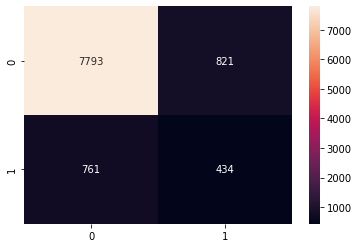

In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_test)

cm = confusion_matrix(y_test, y_pred_dtc)
sns.heatmap(cm, annot=True, fmt='g') 

acc_dtc = (cm.ravel()[0]+cm.ravel()[3])/sum(cm.ravel())
TPR_dtc = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[2])
FPR_dtc= cm.ravel()[1]/(cm.ravel()[1]+cm.ravel()[0])
print('Accuracy is: %.4f' %acc_dtc)
print('TPR is: %.4f' % TPR_dtc)
print('FPR is: %.4f' % FPR_dtc)

prob_dtc = dtc.predict_proba(X_test)[:,1]
#print('AUC Score is: %.4f' % sklearn.metrics.roc_auc_score(y_test, prob_dtc))

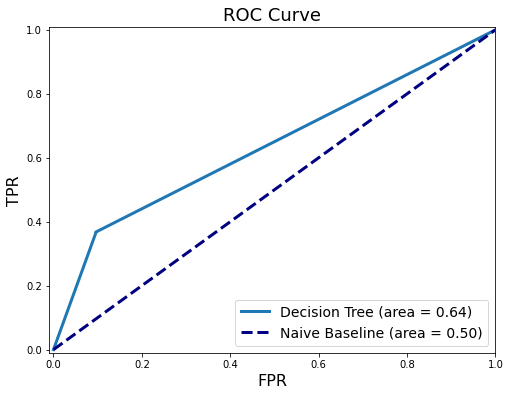

In [ ]:
fpr, tpr, _ = roc_curve(y_test, prob_dtc)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Decision Tree (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', label='Naive Baseline (area = 0.50)')
plt.legend(loc='lower right', fontsize=14)
plt.show()

Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy is: 0.8915
TPR is: 0.2259
FPR is: 0.0161


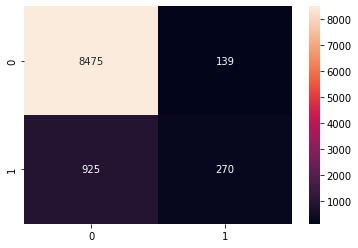

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_prob_log = logreg.predict(X_test)
y_pred_log = (y_prob_log >= .5).astype(int)


cm_log = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm_log, annot=True, fmt='g')

acc_log = (cm_log.ravel()[0]+cm_log.ravel()[3])/sum(cm_log.ravel())
TPR_log = cm_log.ravel()[3]/(cm_log.ravel()[3]+cm_log.ravel()[2])
FPR_log = cm_log.ravel()[1]/(cm_log.ravel()[1]+cm_log.ravel()[0])
print('Accuracy is: %.4f' %acc_log)
print('TPR is: %.4f' % TPR_log)
print('FPR is: %.4f' % FPR_log)
#print('AUC Score is: %.4f' % sklearn.metrics.roc_auc_score(y_test, prob_logreg))

prob_logreg = logreg.predict_proba(X_test)[:,1]
#print(prob_logreg)


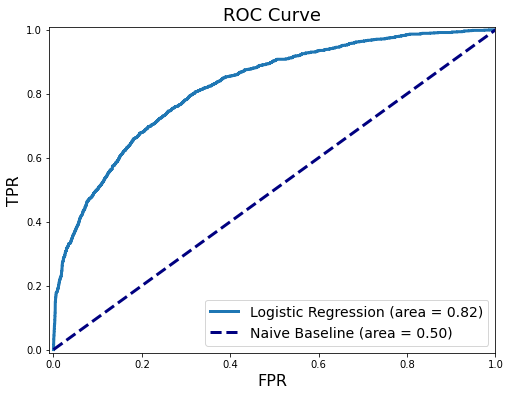

In [ ]:
fpr, tpr, _ = roc_curve(y_test, prob_logreg)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Logistic Regression (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', label='Naive Baseline (area = 0.50)')
plt.legend(loc='lower right', fontsize=14)
plt.show()

Random Forest

Accuracy is: 0.8809
TPR is: 0.3188
FPR is: 0.0411


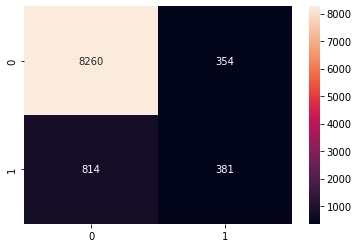

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='g')

acc_rf = (cm_rf.ravel()[0]+cm_rf.ravel()[3])/sum(cm_rf.ravel())
TPR_rf = cm_rf.ravel()[3]/(cm_rf.ravel()[3]+cm_rf.ravel()[2])
FPR_rf = cm_rf.ravel()[1]/(cm_rf.ravel()[1]+cm_rf.ravel()[0])
print('Accuracy is: %.4f' %acc_rf)
print('TPR is: %.4f' % TPR_rf)
print('FPR is: %.4f' % FPR_rf)
#print('AUC Score is: %.4f' % sklearn.metrics.roc_auc_score(y_test, prob_rf))

prob_rf = rf.predict_proba(X_test)[:,1]
#print(prob_rf)


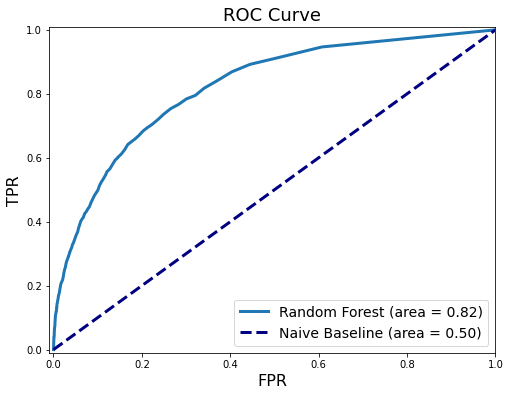

In [ ]:
fpr, tpr, _ = roc_curve(y_test, prob_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Random Forest (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', label='Naive Baseline (area = 0.50)')
plt.legend(loc='lower right', fontsize=14)
plt.show()

In [ ]:
max(prob_logreg), max(prob_dtc), max(prob_rf)

(0.9755724219870703, 1.0, 1.0)

#### Problem: Class Imbalance

12.449598572702945 %


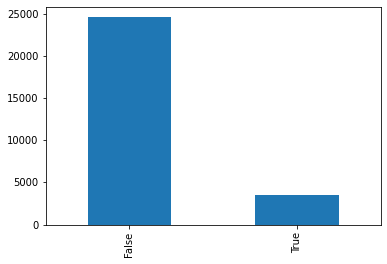

In [ ]:
final['shot_outcome'].value_counts().plot(kind= 'bar');
print((final['shot_outcome']==True).sum()/len(final)*100,'%')

### Three Strategies to Combat Class Imbalance and Improve xG models

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.tree import plot_tree
from sklearn.ensemble import GradientBoostingClassifier

#### 1. Decision Trees perform well on Imbalanced Data

Simple Decision Tree

In [ ]:
grid_values = {'ccp_alpha': np.linspace(0, 0.10, 201)}
           
dtc = DecisionTreeClassifier(min_samples_leaf = 5, random_state = 1)
dtc_cv = GridSearchCV(dtc, param_grid = grid_values, scoring = 'accuracy', cv=5, verbose=1)
dtc_cv.fit(X_train, y_train)

Fitting 5 folds for each of 201 candidates, totalling 1005 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(min_samples_leaf=5,
                                              random_state=1),
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
       0.004 , 0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075,
       0.008 , 0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115,
       0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 , 0.0155,
       0.016 , 0.0165, 0.017 , 0.0175, 0.0...
       0.072 , 0.0725, 0.073 , 0.0735, 0.074 , 0.0745, 0.075 , 0.0755,
       0.076 , 0.0765, 0.077 , 0.0775, 0.078 , 0.0785, 0.079 , 0.0795,
       0.08  , 0.0805, 0.081 , 0.0815, 0.082 , 0.0825, 0.083 , 0.0835,
       0.084 , 0.0845, 0.085 , 0.0855, 0.086 , 0.0865, 0.087 , 0.0875,
       0.088 , 0.0885, 0.089 , 0.0895, 0.09  , 0.0905, 0.091 , 0.0915,
       0.092 , 0.0925, 0.093 , 0.0935, 0.094 , 0.0945, 0.095 , 0.0955,
       0.096 , 0.0965, 0.097 , 0.0975, 0.098 , 0.0985, 0.0

In [ ]:
print("Best ccp_alpha is", dtc_cv.best_params_['ccp_alpha'])

Best ccp_alpha is 0.0005


In [ ]:
y_pred = dtc_cv.best_estimator_.predict(X_test)
y_prob = dtc_cv.best_estimator_.predict_proba(X_test)[:,1]

dtc_cv_acc = accuracy_score(y_test, y_pred)
dtc_cv_auc = roc_auc_score(np.array(y_test), y_prob)
print('Decision Tree Accuracy:', dtc_cv_acc)
print('Decision Tree AUC:', dtc_cv_auc)

Decision Tree Accuracy: 0.8879600367009889
Decision Tree AUC: 0.8283396367779821


In [ ]:
dtc_small = DecisionTreeClassifier(max_leaf_nodes=7, ccp_alpha=.0005)
dtc_small = dtc_small.fit(X_train, y_train)

Node count = 13


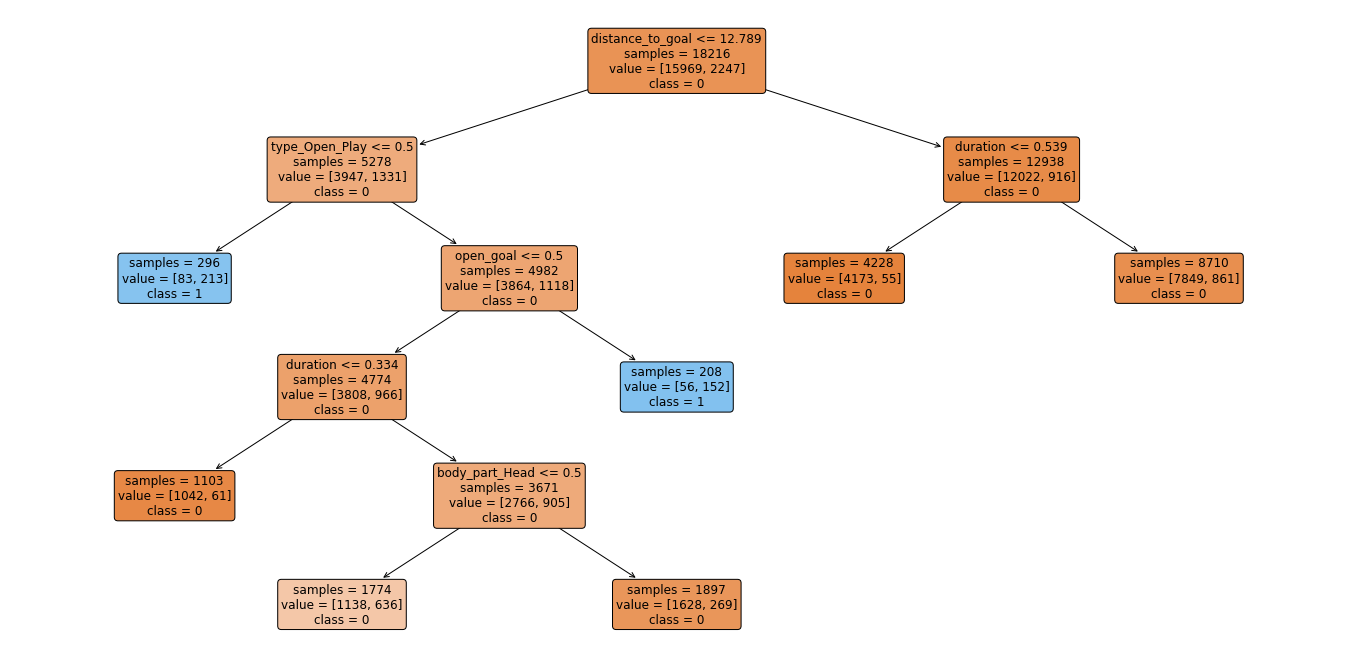

In [ ]:
print('Node count =', dtc_small.tree_.node_count)
plt.figure(figsize=(24,12))
plot_tree(dtc_small, 
          feature_names=X_train.columns, 
          class_names=['0','1'], 
          filled=True,
          impurity=False,
          rounded=True,
          fontsize=12)  
plt.show() 

In [ ]:
imp = pd.DataFrame({'Feature' : X_train.columns, 
              'Importance score': 100*dtc_cv.best_estimator_.feature_importances_}).round(1)

imp.sort_values(by='Importance score', ascending=False).head(5)

,Feature,Importance score
7,distance_to_goal,37.3
0,duration,15.3
13,type_Open_Play,13.9
22,body_part_Head,11.7
3,open_goal,11.3


Random Forest

In [ ]:
grid_values = {'max_features': range(1, len(X_train.columns)+1)}
           
rf = RandomForestClassifier(random_state=1)
rf_cv = GridSearchCV(rf, param_grid = grid_values, scoring = 'accuracy', cv=5, verbose=1)
rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 26 candidates, totalling 130 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_features': range(1, 27)}, scoring='accuracy',
             verbose=1)

In [ ]:
print("Best max_features is", rf_cv.best_params_['max_features'])

Best max_features is 19


In [ ]:
y_pred = rf_cv.best_estimator_.predict(X_test)
y_prob = rf_cv.best_estimator_.predict_proba(X_test)[:,1]

rf_cv_acc = accuracy_score(y_test, y_pred)
rf_cv_auc = roc_auc_score(np.array(y_test), y_prob)
print('Random Forest Accuracy:', rf_cv_acc)
print('Random Forest AUC:', rf_cv_auc)

Random Forest Accuracy: 0.8802120501580182
Random Forest AUC: 0.825483350240888


In [ ]:
imp = pd.DataFrame({'Feature' : X_train.columns, 
              'Importance score': 100*rf_cv.best_estimator_.feature_importances_}).round(1)

imp.sort_values(by='Importance score', ascending=False).head(5)

,Feature,Importance score
0,duration,37.9
7,distance_to_goal,37.7
3,open_goal,2.6
22,body_part_Head,2.5
8,goal_zone,2.5


"Vanilla Bagging"

In [ ]:
bag = RandomForestClassifier(max_features = len(X_train.columns))
bag.fit(X_train, y_train);

In [ ]:
y_pred = bag.predict(X_test)
y_prob = bag.predict_proba(X_test)[:,1]

bag_acc = accuracy_score(y_test, y_pred)
bag_auc = roc_auc_score(np.array(y_test), y_prob)
print('Bagging Accuracy:', bag_acc)
print('Bagging AUC:', bag_auc)

Bagging Accuracy: 0.8785808950963401
Bagging AUC: 0.8192005818679963


In [ ]:
imp = pd.DataFrame({'Feature' : X_train.columns, 
              'Importance score': 100*bag.feature_importances_}).round(1)

imp.sort_values(by='Importance score', ascending=False).head(5)

,Feature,Importance score
7,distance_to_goal,38.2
0,duration,37.9
22,body_part_Head,2.9
3,open_goal,2.8
14,type_Penalty,2.3


Gradient Boosting Tree

In [ ]:
grid_values = {'n_estimators': range(20,111,10)}

gbc = GradientBoostingClassifier(random_state=1)
gbc_cv = GridSearchCV(gbc, param_grid = grid_values, scoring = 'accuracy', cv=5, verbose=1)
gbc_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=1),
             param_grid={'n_estimators': range(20, 111, 10)},
             scoring='accuracy', verbose=1)

In [ ]:
print("Best n_estimators is", gbc_cv.best_params_['n_estimators'])

Best n_estimators is 110


In [ ]:
y_pred = gbc_cv.best_estimator_.predict(X_test)
y_prob = gbc_cv.best_estimator_.predict_proba(X_test)[:,1]

gbc_acc = accuracy_score(y_test, y_pred)
gbc_auc = roc_auc_score(np.array(y_test), y_prob)
print('Gradient Boosting Accuracy:', gbc_acc)
print('Gradient Boosting AUC:', gbc_auc)

Gradient Boosting Accuracy: 0.8926496075033132
Gradient Boosting AUC: 0.8675513011298457


In [ ]:
imp = pd.DataFrame({'Feature' : X_train.columns, 
              'Importance score': 100*gbc_cv.best_estimator_.feature_importances_}).round(1)

imp.sort_values(by='Importance score', ascending=False).head(5)

,Feature,Importance score
7,distance_to_goal,32.7
0,duration,22.5
22,body_part_Head,9.9
14,type_Penalty,9.3
3,open_goal,6.7


Performance Table

In [ ]:
metrics = {'Model':  ['CART', 'Random Forest', 'Vanilla Bagging', 'Gradient Boosting'],
        'Accuracy': [dtc_cv_acc, rf_cv_acc, bag_acc, gbc_acc],
       'AUC': [dtc_cv_auc, rf_cv_auc, bag_auc, gbc_auc]
        }
performance = pd.DataFrame(metrics)
performance

,Model,Accuracy,AUC
0,CART,0.887960,0.828340
1,Random Forest,0.880212,0.825483
2,Vanilla Bagging,0.878581,0.819201
3,Gradient Boosting,0.892650,0.867551


#### 2. Oversampling the Minority Class

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [ ]:
scaler = preprocessing.StandardScaler().fit(X_ros)
X_scaled = scaler.transform(X_ros)
X_scaled_test = scaler.transform(X_test)

##### Logistic Regression with Over Sampling and Scaling Data


In [ ]:
logreg = LogisticRegression(random_state=1)
logreg.fit(X_scaled, y_ros)

LogisticRegression(random_state=1)

In [ ]:
y_prob = logreg.predict(X_scaled_test)
y_pred = (y_prob >= .5).astype(int)

log_acc = accuracy_score(y_test, y_pred)
log_auc = roc_auc_score(np.array(y_test), y_prob)
print('Logistic Regression Accuracy:', log_acc)
print('Logistic Regression AUC:', log_auc)

Logistic Regression Accuracy: 0.7538994800693241
Logistic Regression AUC: 0.7465528888798666


##### LDA with Over Sampling and Scaling Data

In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_scaled, y_ros)

LinearDiscriminantAnalysis()

In [ ]:
lda_pred = lda.predict(X_scaled_test)
lda_prob = lda.predict_proba(X_scaled_test)[:,1]

lda_acc = accuracy_score(y_test, lda_pred)
lda_auc = roc_auc_score(np.array(y_test), lda_prob)
print('LDA Accuracy:', lda_acc)
print('LDA AUC:', lda_auc)

LDA Accuracy: 0.7459475991436436
LDA AUC: 0.8233490886555477


Performance

In [ ]:
metrics = {'Model':  ['Logistic Regression', 'LDA'],
        'Accuracy': [log_acc, lda_acc],
       'AUC': [log_auc, lda_auc]
        }
performance = pd.DataFrame(metrics)
print("With Over-Sampling and Scaling")
performance

With Over-Sampling and Scaling


,Model,Accuracy,AUC
0,Logistic Regression,0.753899,0.746553
1,LDA,0.745948,0.823349


#### 3. Cross-Validating a Class Imbalance Parameter

XGB Classifier

In [ ]:
import xgboost as xgb

In [ ]:
(y_train==False).sum()/(y_train==True).sum()

7.106809078771696

In [ ]:
weights = [1, 7, 10, 25, 50, 75, 100, 1000]
n_estimators = range(50, 400, 50)
grid_values = {'scale_pos_weight': weights,
               'n_estimators': n_estimators}

In [ ]:
XGB = xgb.XGBClassifier(objective = "binary:logistic", learning_rate = 0.1, max_depth = 5, alpha = 10)
XGB_cv = GridSearchCV(XGB, param_grid = grid_values, scoring='accuracy', cv=5, verbose=1)
XGB_cv.fit(X_train, y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


GridSearchCV(cv=5, estimator=XGBClassifier(alpha=10, max_depth=5),
             param_grid={'n_estimators': range(50, 400, 50),
                         'scale_pos_weight': [1, 7, 10, 25, 50, 75, 100, 1000]},
             scoring='accuracy', verbose=1)

In [ ]:
print("Best scale_pos_weight is", XGB_cv.best_params_['scale_pos_weight'])
print("Best n_estimators is", XGB_cv.best_params_['n_estimators'])

Best scale_pos_weight is 1
Best n_estimators is 50


In [ ]:
y_pred = XGB_cv.best_estimator_.predict(X_test)
y_prob = XGB_cv.best_estimator_.predict_proba(X_test)[:,1]

xgb_acc = accuracy_score(y_test, y_pred)
xgb_auc = roc_auc_score(np.array(y_test), y_prob)
print('XGB Accuracy:', xgb_acc)
print('XGB AUC:', xgb_auc)

XGB Accuracy: 0.8907126108675706
XGB AUC: 0.8677775653760348


In [ ]:
imp = pd.DataFrame({'Feature' : X_train.columns, 
              'Importance score': 100*XGB_cv.best_estimator_.feature_importances_}).round(1)

imp.sort_values(by='Importance score', ascending=False).head(5)

,Feature,Importance score
8,goal_zone,33.599998
14,type_Penalty,15.100000
3,open_goal,9.400000
22,body_part_Head,7.500000
13,type_Open_Play,4.900000


Logistic Regression

In [ ]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [ ]:
parameter = {'class_weight':[{1: w} for w in [.75, 1, 1.25, 1.5, 1.75, 2]]}

In [ ]:
log_weight = LogisticRegression(random_state=1)
log_cv = GridSearchCV(log_weight, param_grid = parameter, scoring='accuracy', cv=5, verbose=1)
log_cv.fit(X_scaled_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=1),
             param_grid={'class_weight': [{1: 0.75}, {1: 1}, {1: 1.25},
                                          {1: 1.5}, {1: 1.75}, {1: 2}]},
             scoring='accuracy', verbose=1)

In [ ]:
print("Best class_weight is", log_cv.best_params_['class_weight'])

Best class_weight is {1: 1.25}


In [ ]:
y_prob = log_cv.best_estimator_.predict(X_scaled_test)
y_pred = (y_prob >= .5).astype(int)

log_acc = accuracy_score(y_test, y_pred)
log_auc = roc_auc_score(np.array(y_test), y_prob)
print('XGB Accuracy:', log_acc)
print('XGB AUC:', log_auc)

XGB Accuracy: 0.8875522479355694
XGB AUC: 0.6141301293376242


In [ ]:
metrics = {'Model':  ['XGB', 'Logistic Regression'],
        'Accuracy': [xgb_acc, log_acc],
       'AUC': [xgb_auc, log_auc]
       }
performance = pd.DataFrame(metrics)
print("Cross-Validating Class Weight Parameters")
performance

Cross-Validating Class Weight Parameters


,Model,Accuracy,AUC
0,XGB,0.890713,0.867778
1,Logistic Regression,0.887552,0.614130


### Bootstrap Comparing the Best Models

In [ ]:
metrics = {'Model':  ['XGB', 'Random Forest', 'Gradient Boosting'],
        'Accuracy': [xgb_acc, rf_cv_acc, gbc_acc],
       'AUC': [xgb_auc, rf_cv_auc, gbc_auc]
       }
performance = pd.DataFrame(metrics)
print("Best Performing Models")
performance

Best Performing Models


,Model,Accuracy,AUC
0,XGB,0.890713,0.867778
1,Random Forest,0.880212,0.825483
2,Gradient Boosting,0.892650,0.867551


In [ ]:
rf = rf_cv.best_estimator_
xgb = XGB_cv.best_estimator_
gbc = gbc_cv.best_estimator_

In [ ]:
def bootstrap_comparison(test_data, test_label, model1, model2, sample=500, random_state=1):
    
    output_array=np.zeros(sample)
    output_array[:]=np.nan
    
    for i in range(sample):
        bs_index = np.random.choice(test_data.index, len(test_data.index), replace=True)
        bs_data = test_data.loc[bs_index]
        bs_label = test_label.loc[bs_index]
        
        bs_predicted1 = model1.predict(bs_data)
        acc1 = accuracy_score(bs_predicted1, bs_label)
        
        bs_predicted2 = model2.predict(bs_data)
        acc2 = accuracy_score(bs_predicted2, bs_label)
        
        output_array[i] = acc1 - acc2
            
    output_df = pd.DataFrame(output_array)
    return output_df

In [ ]:
bs = bootstrap_comparison(X_test, y_test, rf, xgb, sample = 5000)
np.percentile(bs[0], 2.5), np.percentile(bs[0], 97.5)

(-0.014374553981037819, -0.0062136813130798454)

In [ ]:
bs = bootstrap_comparison(X_test, y_test, rf, gbc, sample = 5000)
np.percentile(bs[0], 2.5), np.percentile(bs[0], 97.5)

(-0.016923233764909784, -0.008204200224283828)

In [ ]:
bs = bootstrap_comparison(X_test, y_test, xgb, gbc, sample = 5000)
np.percentile(bs[0], 2.5), np.percentile(bs[0], 97.5)

(-0.0035681516974207517, -0.00020389438270973503)

In [ ]:
def bootstrap_comparison_auc(test_data, test_label, model1, model2, sample=500, random_state=1):
    
    output_array=np.zeros(sample)
    output_array[:]=np.nan
    
    for i in range(sample):
        bs_index = np.random.choice(test_data.index, len(test_data.index), replace=True)
        bs_data = test_data.loc[bs_index]
        bs_label = test_label.loc[bs_index]
        
        bs_predicted1 = model1.predict_proba(bs_data)[:,1]
        auc1 = roc_auc_score(np.array(bs_label), bs_predicted1)
        
        bs_predicted2 = model2.predict_proba(bs_data)[:,1]
        auc2 = roc_auc_score(np.array(bs_label), bs_predicted2)
        
        output_array[i] = auc1 - auc2
            
    output_df = pd.DataFrame(output_array)
    return output_df

In [ ]:
bs = bootstrap_comparison_auc(X_test, y_test, rf, xgb, sample = 5000)
np.percentile(bs[0], 2.5), np.percentile(bs[0], 97.5)

(-0.04921141637267015, -0.035340727077367864)

In [ ]:
bs = bootstrap_comparison_auc(X_test, y_test, rf, gbc, sample = 5000)
np.percentile(bs[0], 2.5), np.percentile(bs[0], 97.5)

(-0.04891349824815752, -0.03571400002289582)

In [ ]:
bs = bootstrap_comparison_auc(X_test, y_test, xgb, gbc, sample = 5000)
np.percentile(bs[0], 2.5), np.percentile(bs[0], 97.5)

(-0.002100545548768201, 0.0025719420562038044)

### Based on analysis above, Gradient Boosting Classifier is our chosen model

In [ ]:
def bootstrap_validation_acc(test_data, test_label, model, sample=500, random_state=1):
    
    output_array=np.zeros(sample)
    output_array[:]=np.nan
    
    for i in range(sample):
        bs_index = np.random.choice(test_data.index, len(test_data.index), replace=True)
        bs_data = test_data.loc[bs_index]
        bs_label = test_label.loc[bs_index]
        
        bs_predicted = model.predict(bs_data)
        acc = accuracy_score(bs_label, bs_predicted)
        
        output_array[i] = acc
            
    output_df = pd.DataFrame(output_array)
    return output_df

In [ ]:
def bootstrap_validation_auc(test_data, test_label, model, sample=500, random_state=1):
    
    output_array=np.zeros(sample)
    output_array[:]=np.nan
    
    for i in range(sample):
        bs_index = np.random.choice(test_data.index, len(test_data.index), replace=True)
        bs_data = test_data.loc[bs_index]
        bs_label = test_label.loc[bs_index]
        
        bs_predicted = model.predict_proba(bs_data)[:,1]
        auc = roc_auc_score(np.array(bs_label), bs_predicted)
        
        output_array[i] = auc
            
    output_df = pd.DataFrame(output_array)
    return output_df

In [ ]:
bs_acc = bootstrap_validation_acc(X_test, y_test, gbc, sample = 5000)
print('The CI for the test set accuracy of the Gradient Boosting model is (', 
      np.percentile(bs_acc[0], 2.5), ',', np.percentile(bs_acc[0], 97.5), ')')

The CI for the test set accuracy of the Gradient Boosting model is ( 0.8866347232133754 , 0.8986644917932511 )


In [ ]:
bs_auc = bootstrap_validation_auc(X_test, y_test, gbc, sample = 5000)
print('The CI for the test set AUC of the Gradient Boosting model is (', 
      np.percentile(bs_auc[0], 2.5), ',', np.percentile(bs_auc[0], 97.5), ')')

The CI for the test set AUC of the Gradient Boosting model is ( 0.8579469366636326 , 0.8771939977438896 )


In [ ]:
imp = pd.DataFrame({'Feature' : X_train.columns, 
              'Importance score': 100*gbc.feature_importances_}).round(1)

imp.sort_values(by='Importance score', ascending=False).head(5)

,Feature,Importance score
7,distance_to_goal,32.7
0,duration,22.5
22,body_part_Head,9.9
14,type_Penalty,9.3
3,open_goal,6.7
